# Vizzuality: science code challenge  
This notebook contains the code developed for the code challenge as part of the selection process for the position at the science team in Vizzuality.  
  
The process involves the analysis of a dataset from the [SPAM 2010 data](https://www.mapspam.info/data/), and in particular the data regarding physical area of soy crops. Soy is one of the crops with the fastest increase in demand (and therefore in production) over the past decades, mainly due to its use for animal feeding. Such rapid increase in global soy production also involves the risk of deforestation to expand crops and pasture lands, which is regarded as the main threat associated with these crops.  

The following code shows the full process, from loading and preparing the data to visualizing and discussing the main insights extracted from it.

## Dataset preparation

First step is loading the required libraries and setting up the path to the work folder and the data. For the libraries, I tried to include as little as necessary to keep reproducibility as simple as possible.  
  
(Note: the code has been developed using R 4.0.5 on Windows 10)

In [2]:
library(tidyverse) #for multi-purpose data transformation and visualization
library(sf) #to work with spatial objects
library(here) #to manage the path to the main folder
library("rnaturalearth") #to retrieve background maps for visualization
library("rnaturalearthdata") #background maps data

In [3]:
path <- here()
path_data <- file.path(path, "data")


I then stat by creating a list of the csv files of interest. Since I am going to focus on the differences between the production methods used in harvesting, I omitted those ending with "TA" or "TR", as according to the readme they correspond to all the technologies combined (TA) and all the rainfed technologies (TR).

In [4]:
# unzip individual files if first execution, no need for my local project
# list.files(path_data, ".zip", full.names = T) %>% sapply(., unzip, exdir=path_data) 


data_csv_list <- list.files(path_data, ".csv", full.names = T) %>% grep("_TA|_TR",., invert = T, value = T)
basename(data_csv_list)

[1] "spam2010V2r0_global_A_TH.csv" "spam2010V2r0_global_A_TI.csv"
[3] "spam2010V2r0_global_A_TL.csv" "spam2010V2r0_global_A_TS.csv"

I then create a "dictionary" (named list) with the equivalences between the suffix on the file name and the technology used (in the original files, the field corresponding with this information sometimes has empty values).  

According to the [methodology](https://www.mapspam.info/methodology/) from SPAM, the production methods (also referred to as "technologies") include the following:  
- **Rainfed high input**: crops where the main water supply comes from rain, and involve the use of high yield varieties, mechanical labour and/or chemichal product  
- **Rainfed low input**: also based on rain water, but involving manual labour and little use of chemichal supplies.  
- **Irrigation**: crops that involve partial or full irrigation control, usually with similar technologies as the "high input" category  
- **Rainfed subsistance**: crops outside suitable areas where harvest is marginal.

In [5]:
tech_types <- list("TA" = "all technologies",
                    "TI" = "Irrigated",
                    "TH" = "Rainfed high input",
                    "TL" = "Rainfed low input",
                    "TS" = "Rainfed subsistance",
                    "TR" = "Rainfed total")

The dataset used for this challenge involves only **physical area** of the crops, not involving production, yield or economic value. With that in mind the main variables of interest are the coordinates, the production method and the area of the soy crops.  
Since different production methods are included in different files, I looped through the data files to:  
- select only the desired variables (and a few more just in case)  
- retrieve only the records with soy harvested surface  
- include the type of technology (prod. method) as a variable  
- combine the files into a single data.frame  


In [7]:
t1 <- Sys.time()
for(i in 1:length(data_csv_list)){
  print(basename(data_csv_list[i]))
  df_1 <- read.csv(data_csv_list[i], quote = "")
  
  var_soy <- grep("soyb", names(df_1), value = T)
  
  df_clean <- df_1[, c("x", "y", "tech_type", var_soy,
                       "year_data", "source", "name_cntr", "name_adm1")]
  
  names(df_clean)[names(df_clean) == var_soy] <- "soy_beans"
  
  df_clean <- filter(df_clean, soy_beans > 0)
  
  tech_code <- str_split(basename(data_csv_list[i]), pattern = "_") %>%
    unlist() %>% gsub(".csv", "", .) %>% tail(., 1)
  df_clean$Technology <- tech_types[[tech_code]]
  
  if(i == 1){
    df_total <- df_clean
  } else {
    df_total <- rbind(df_total, df_clean)
  }
}
Sys.time() - t1
rm(df_clean, var_soy, tech_code, t1)
#gc()

[1] "spam2010V2r0_global_A_TH.csv"
[1] "spam2010V2r0_global_A_TI.csv"
[1] "spam2010V2r0_global_A_TL.csv"
[1] "spam2010V2r0_global_A_TS.csv"


Time difference of 1.013704 mins

To work with this as spatial data, I transform it into an sf object (spatial data.frame), providing a coordinate system (WSG 84, same as the areas of interest to be used) and selecting the physical area and technology variables. At this pont the dataset has over 500k records from all the world.  
  
  

In [8]:
epsg <-  4326 #WSG 84
df_spatial  <-  st_as_sf(df_total, coords = c('x', 'y'), crs = epsg) %>% select(soy_beans, Technology)
print(paste0("Data frame has ", nrow(df_spatial), " data points"))
head(as.data.frame(df_spatial))

[1] "Data frame has 548418 data points"


,soy_beans,Technology,geometry
,<dbl>,<chr>,<POINT [°]>
1,90.0,Rainfed high input,POINT (123.2917 53.54167)
2,55.8,Rainfed high input,POINT (122.2083 53.45833)
3,90.0,Rainfed high input,POINT (122.2917 53.45833)
4,90.0,Rainfed high input,POINT (122.375 53.45833)
5,90.0,Rainfed high input,POINT (123.0417 53.45833)
6,90.0,Rainfed high input,POINT (123.125 53.45833)


## Loading areas of interest  
I proceed to load the provided file of areas of interest, and separate each into a different object to work with them independently.

In [9]:
interest_areas <- st_read(file.path(path_data, "areas.geojson"))
area_asia <- st_cast(interest_areas$geometry[1], "POLYGON")
area_america <- st_cast(interest_areas$geometry[2], "POLYGON")


Reading layer `areas' from data source `C:\Users\Angel\Documents\VIZZUALITY_CHALLENGE\data\areas.geojson' using driver `GeoJSON'
Simple feature collection with 2 features and 0 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -68.20312 ymin: -28.92163 xmax: 88.94531 ymax: 30.44867
Geodetic CRS:  WGS 84


Since the original dataset spans most of the global surface, I proceed to filter it by the records that fall within the areas of interest.  
  
Messages indicate that the intersection is performed asumming planar coordinates. This can be an issue at certain latitudes (e.g. near the poles), but considering the work areas it shouldn't be a problem in this case (although this will be checked later)

That leaves two sets of data of ~33k records for the Asia area and ~37k records in South America

In [10]:
df_asia <- df_spatial[area_asia,]
df_america <- df_spatial[area_america,]


although coordinates are longitude/latitude, st_intersects assumes that they are planar

although coordinates are longitude/latitude, st_intersects assumes that they are planar

although coordinates are longitude/latitude, st_intersects assumes that they are planar

although coordinates are longitude/latitude, st_intersects assumes that they are planar



In [11]:
print(paste0("Asia's area of interest has ", nrow(df_asia), " data points"))
print(paste0("South America's area of interest has ", nrow(df_america), " data points"))

[1] "Asia's area of interest has 33769 data points"
[1] "South America's area of interest has 37376 data points"


## Visualizing the data

For representation purposes, I first load a map of world borders and crop it into two smaller map areas that can contain each of the areas of interest.

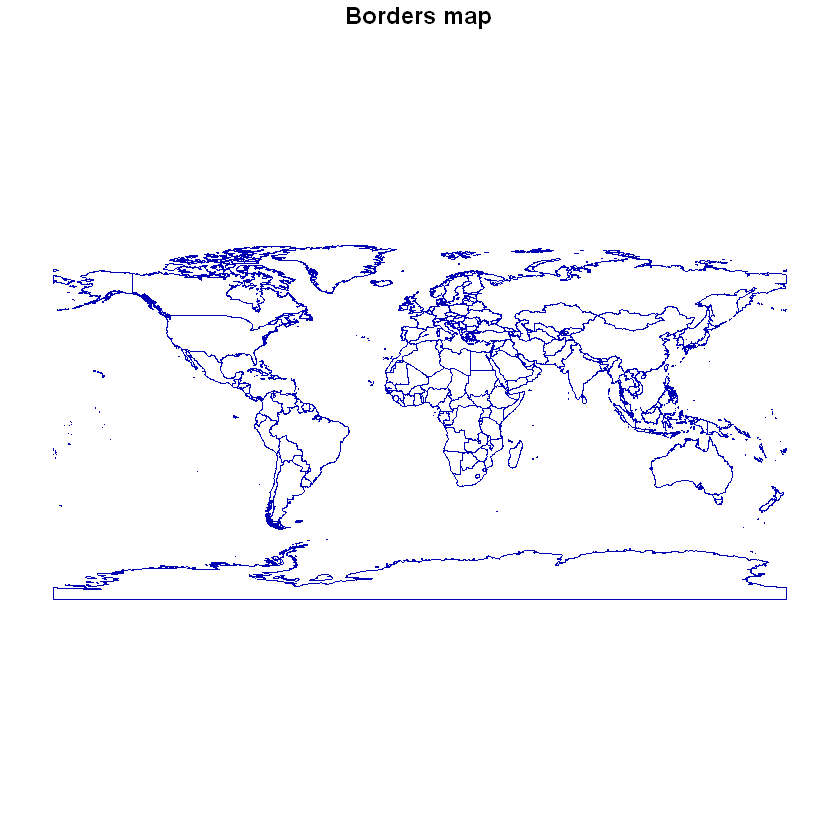

In [18]:
global_map <- ne_countries(scale = 50, returnclass = "sf") %>% st_cast("MULTILINESTRING")
global_map <- global_map[1]
plot(global_map[global_map$scalerank == 1, ], main="Borders map")

although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


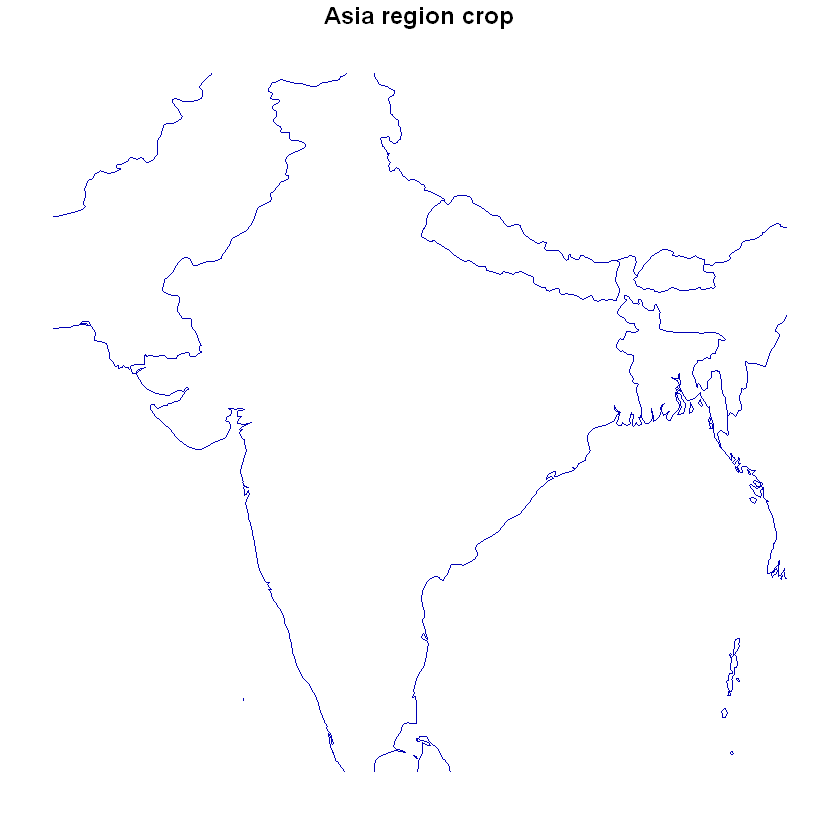

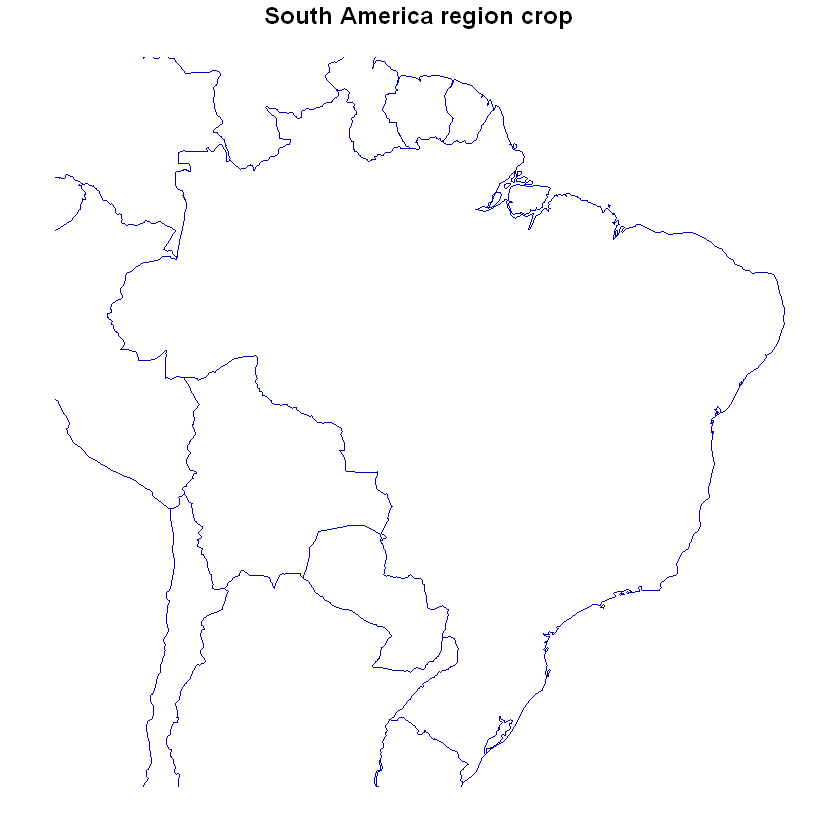

In [19]:
asia_map <- st_crop(global_map, xmin = 65, xmax = 95, ymin = 8.5, ymax = 35)
america_map <- st_crop(global_map, xmin = -77, xmax = -34, ymin = -34, ymax = 7) 


plot(asia_map, main="Asia region crop")
plot(america_map, main="South America region crop")



Now it's the time to visualize the filtered spatial data, to check if it does fit within the areas of interest and get a first glimpse at the distribution of the different types of technology used in soy harvesting.

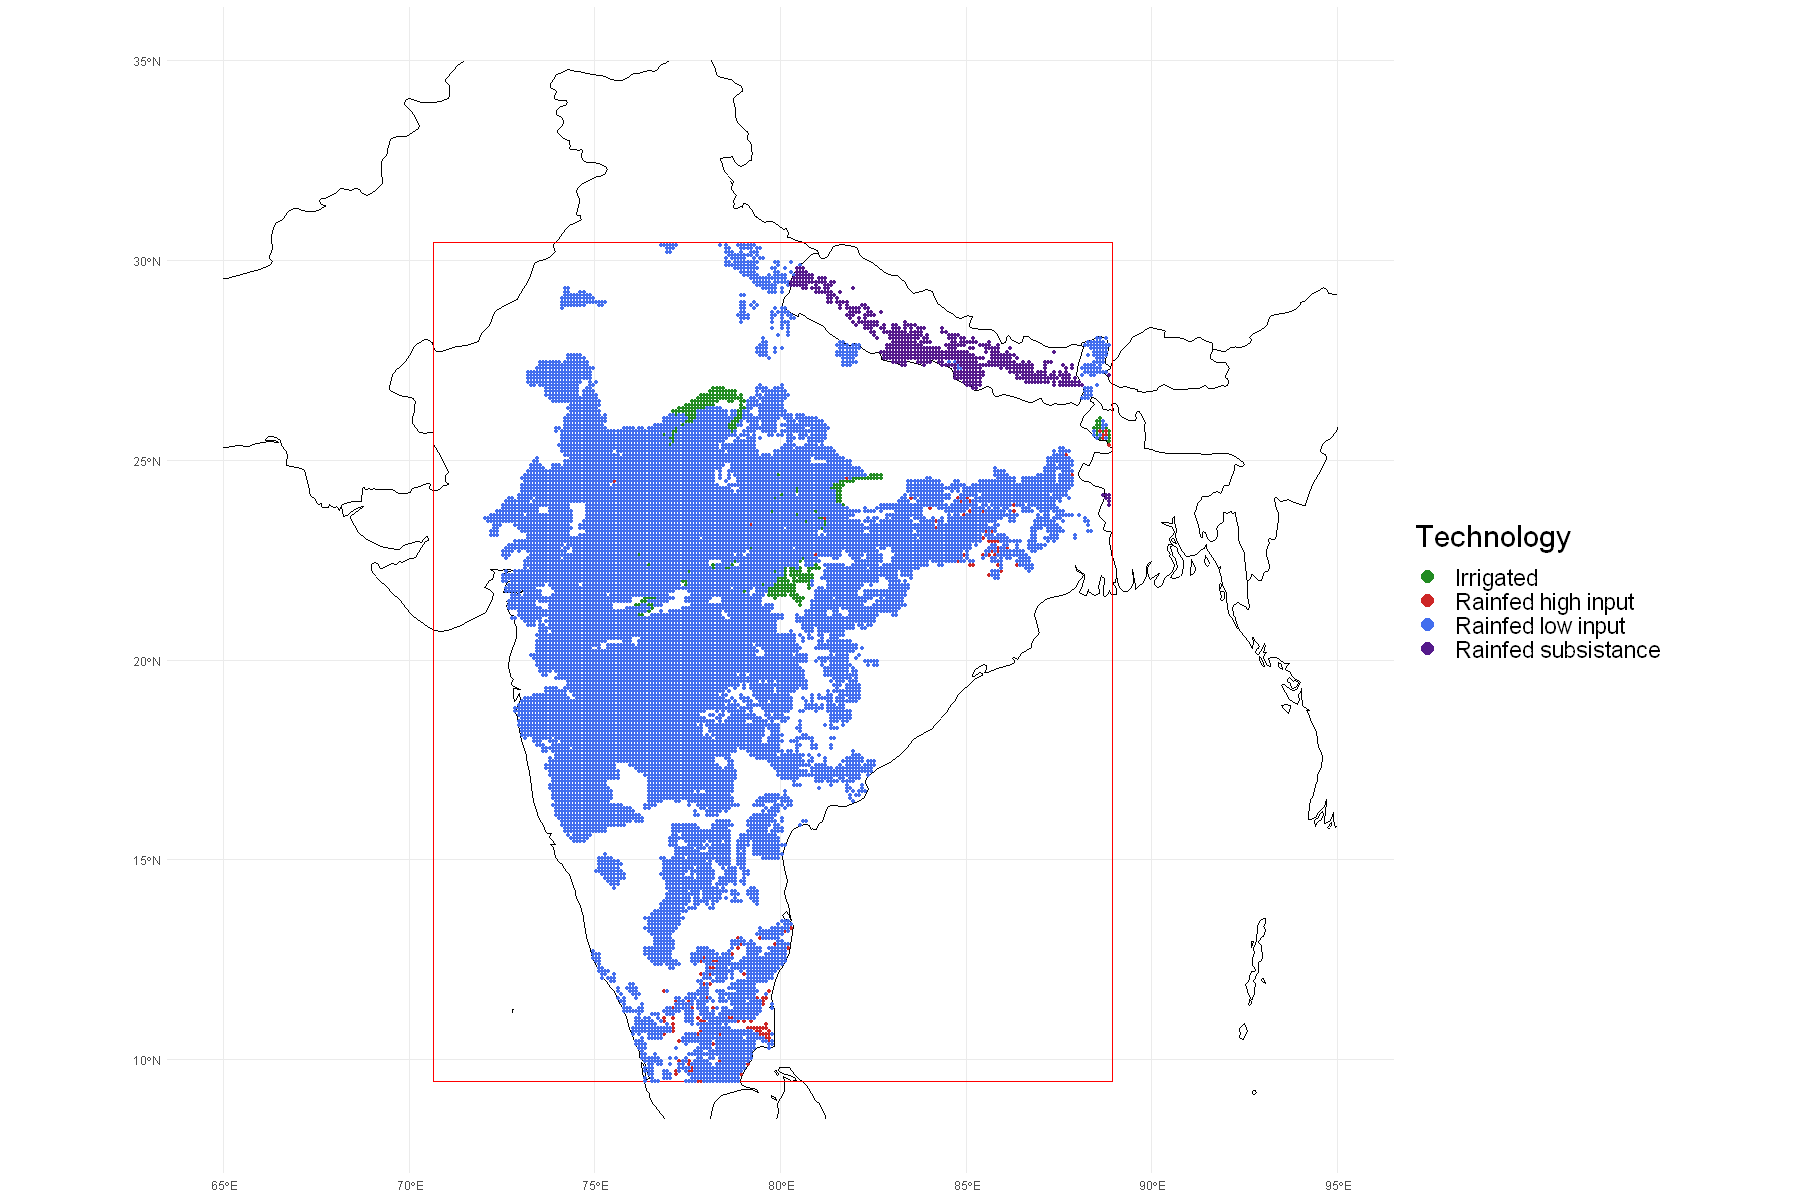

In [20]:
options(repr.plot.width = 18, repr.plot.height = 12, repr.plot.res = 100)
ggplot()+
  geom_sf(data = asia_map, fill = "white") +
  geom_sf(data = area_asia,color = "red", fill = NA)+
  geom_sf(data = df_asia, aes(color=Technology), size = 1)+
  scale_color_manual(values = c("Irrigated"= "forestgreen",
                                "Rainfed high input" = "firebrick3",
                                "Rainfed low input" = "royalblue2",
                                "Rainfed subsistance" = "purple4"))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  theme(legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))

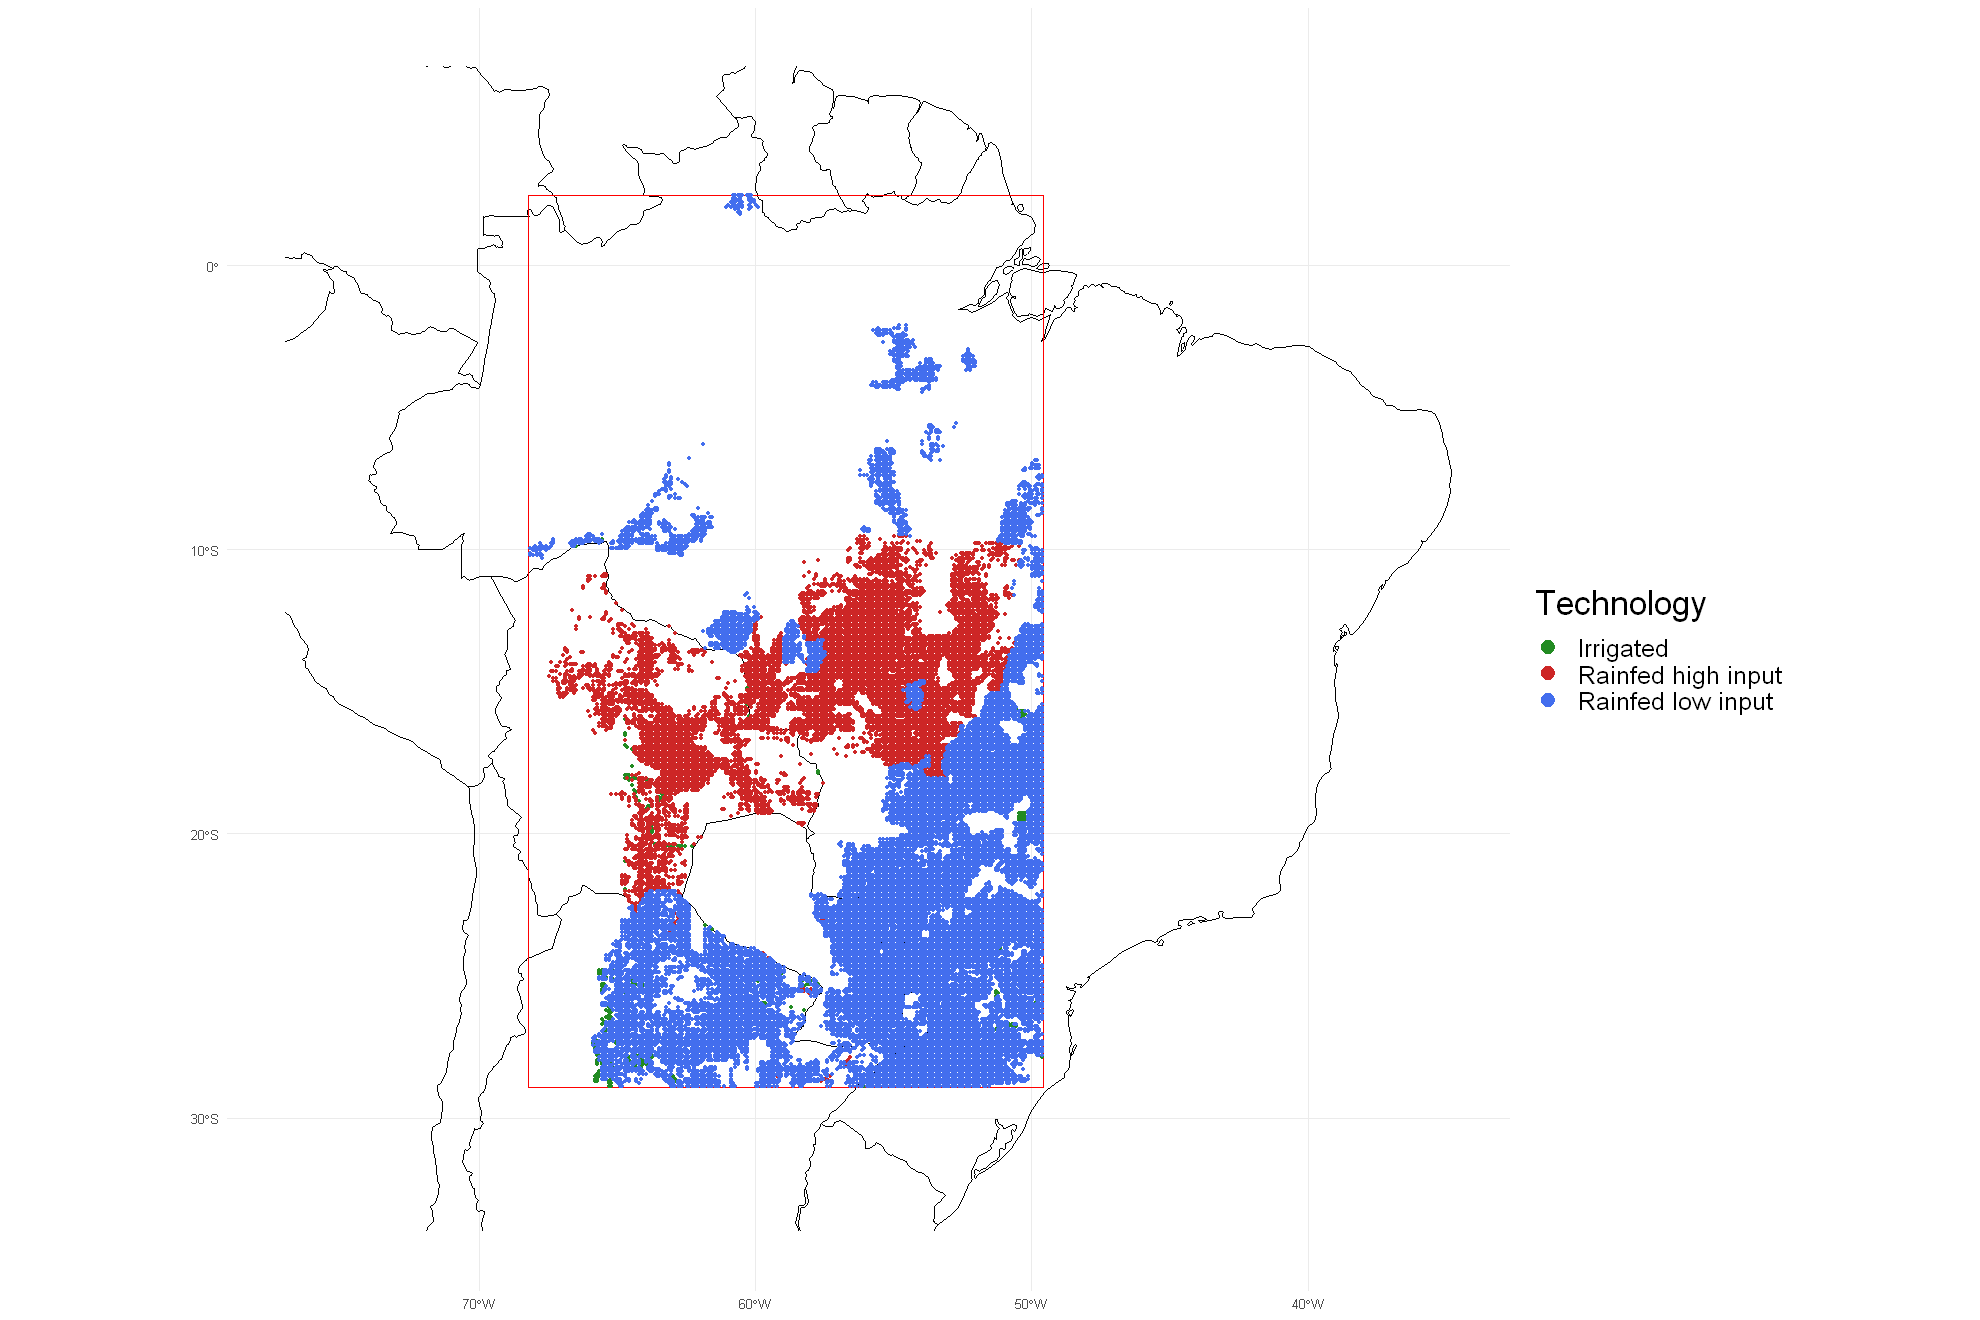

In [21]:
options(repr.plot.width = 18, repr.plot.height = 12, repr.plot.res = 110)
ggplot()+
  geom_sf(data = america_map, fill = "white") +
  geom_sf(data = area_america,color = "red", fill = NA)+
  geom_sf(data = df_america, aes(color=Technology), size = 1)+
  scale_color_manual(values = c("Irrigated"= "forestgreen",
                                "Rainfed high input" = "firebrick3",
                                "Rainfed low input" = "royalblue2",
                                "Rainfed subsistance" = "purple4"))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  theme(legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))

This visualization gives a few initial ideas about the data and the crop's situation:  
- Irrigation is likely the technology that covers the least amount of surface, which makes sense considering logistic and economic costs, compared to rainfed crops.
- Subsistance harvesting is only present in Nepal and Bangladesh within the area of interest.
- In South America, areas of high and low inputs rainfed crops seem similar in extension, however...  
- There seems to be a **massive overlap** between production systems in this visualization.  

To get a better idea, it is better to visualize each system separately


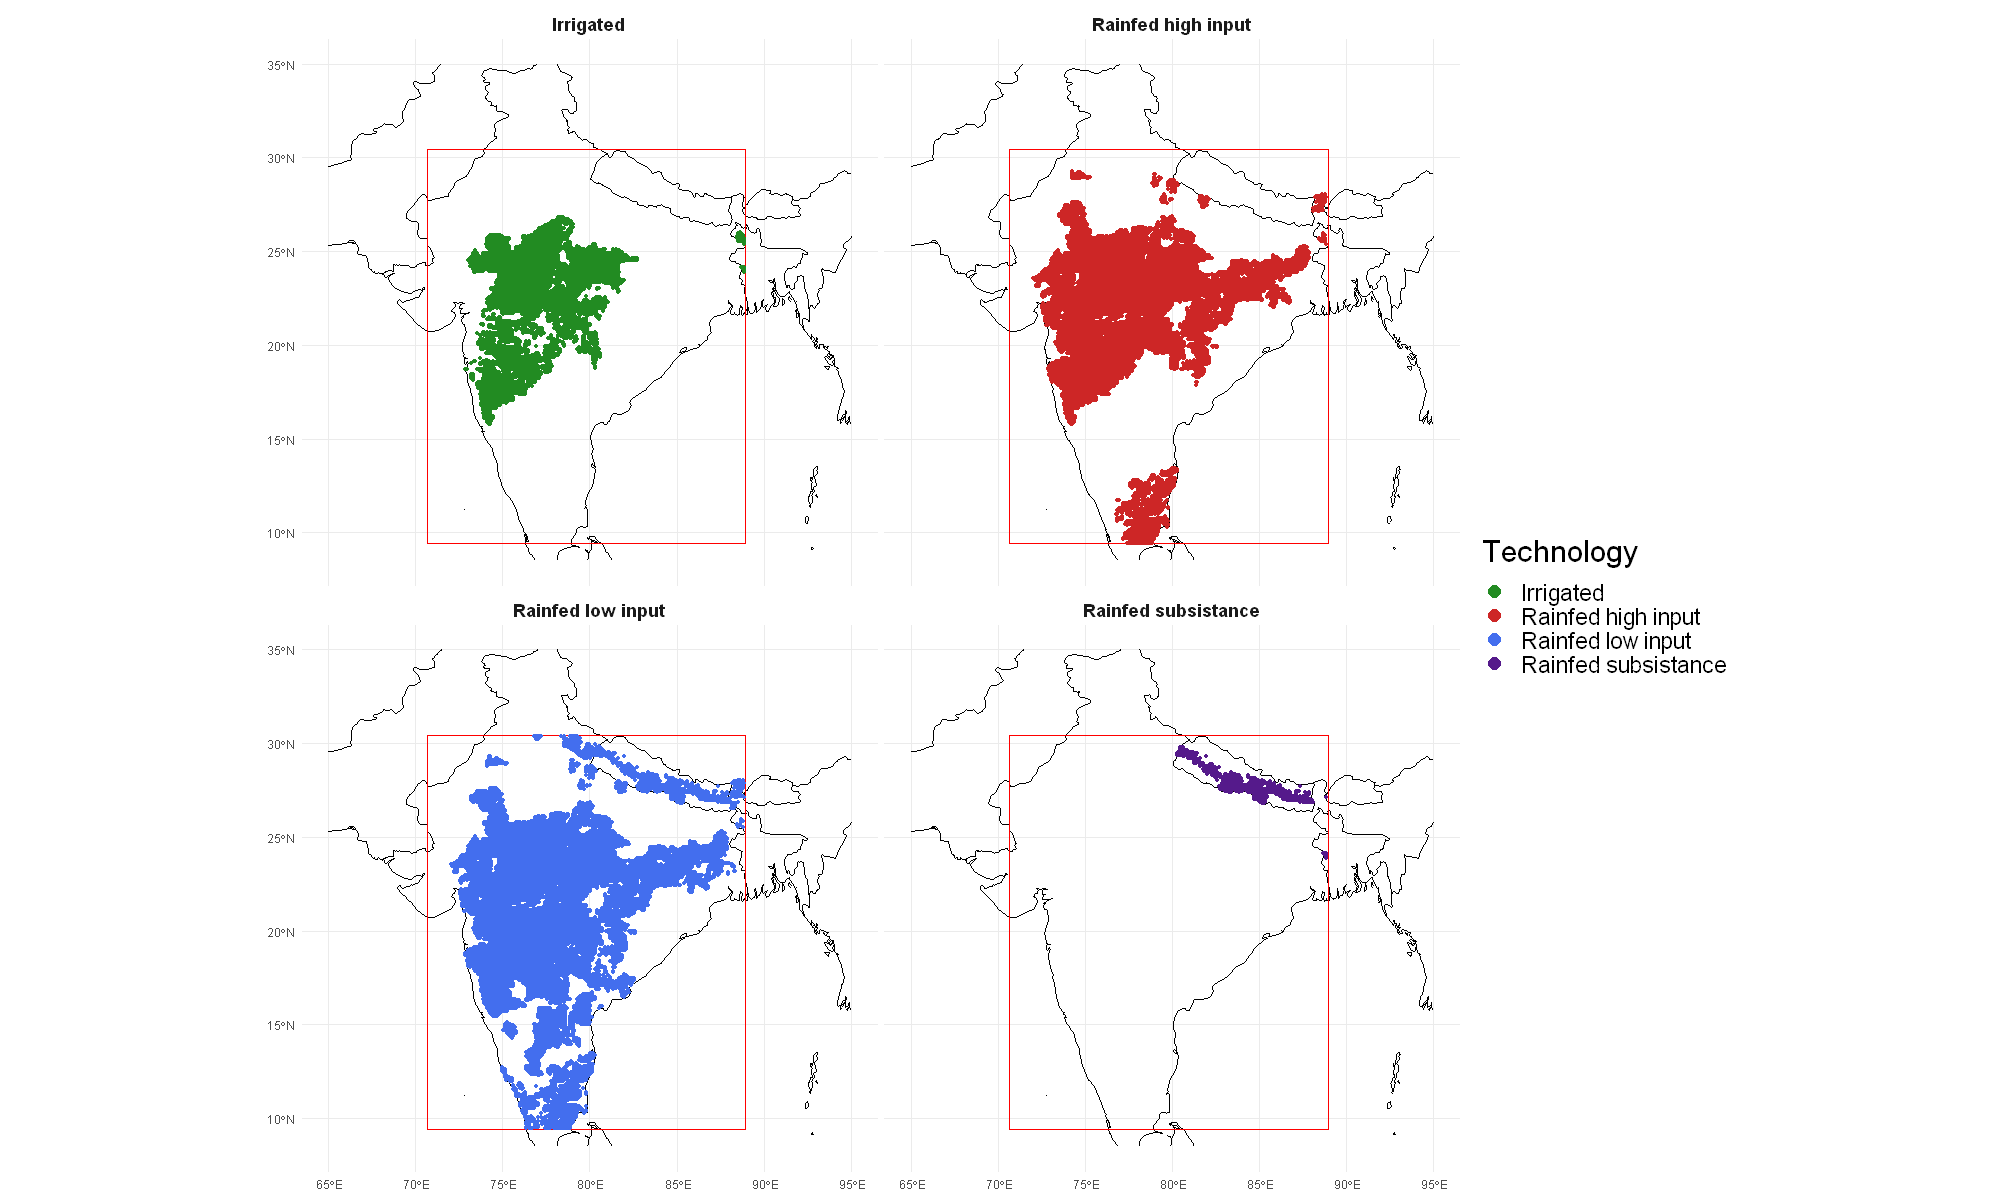

In [22]:
options(repr.plot.width = 20, repr.plot.height = 12, repr.plot.res = 100)
ggplot()+
  geom_sf(data = asia_map, fill = "white") +
  geom_sf(data = area_asia,color = "red", fill = NA)+
  geom_sf(data = df_asia, aes(color=Technology), size = 1)+
  scale_color_manual(values = c("Irrigated"= "forestgreen",
                                "Rainfed high input" = "firebrick3",
                                "Rainfed low input" = "royalblue2",
                                "Rainfed subsistance" = "purple4"))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  theme(strip.text.x = element_text(size=rel(1.5), face = "bold"),
        legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))+
  facet_wrap(~Technology)

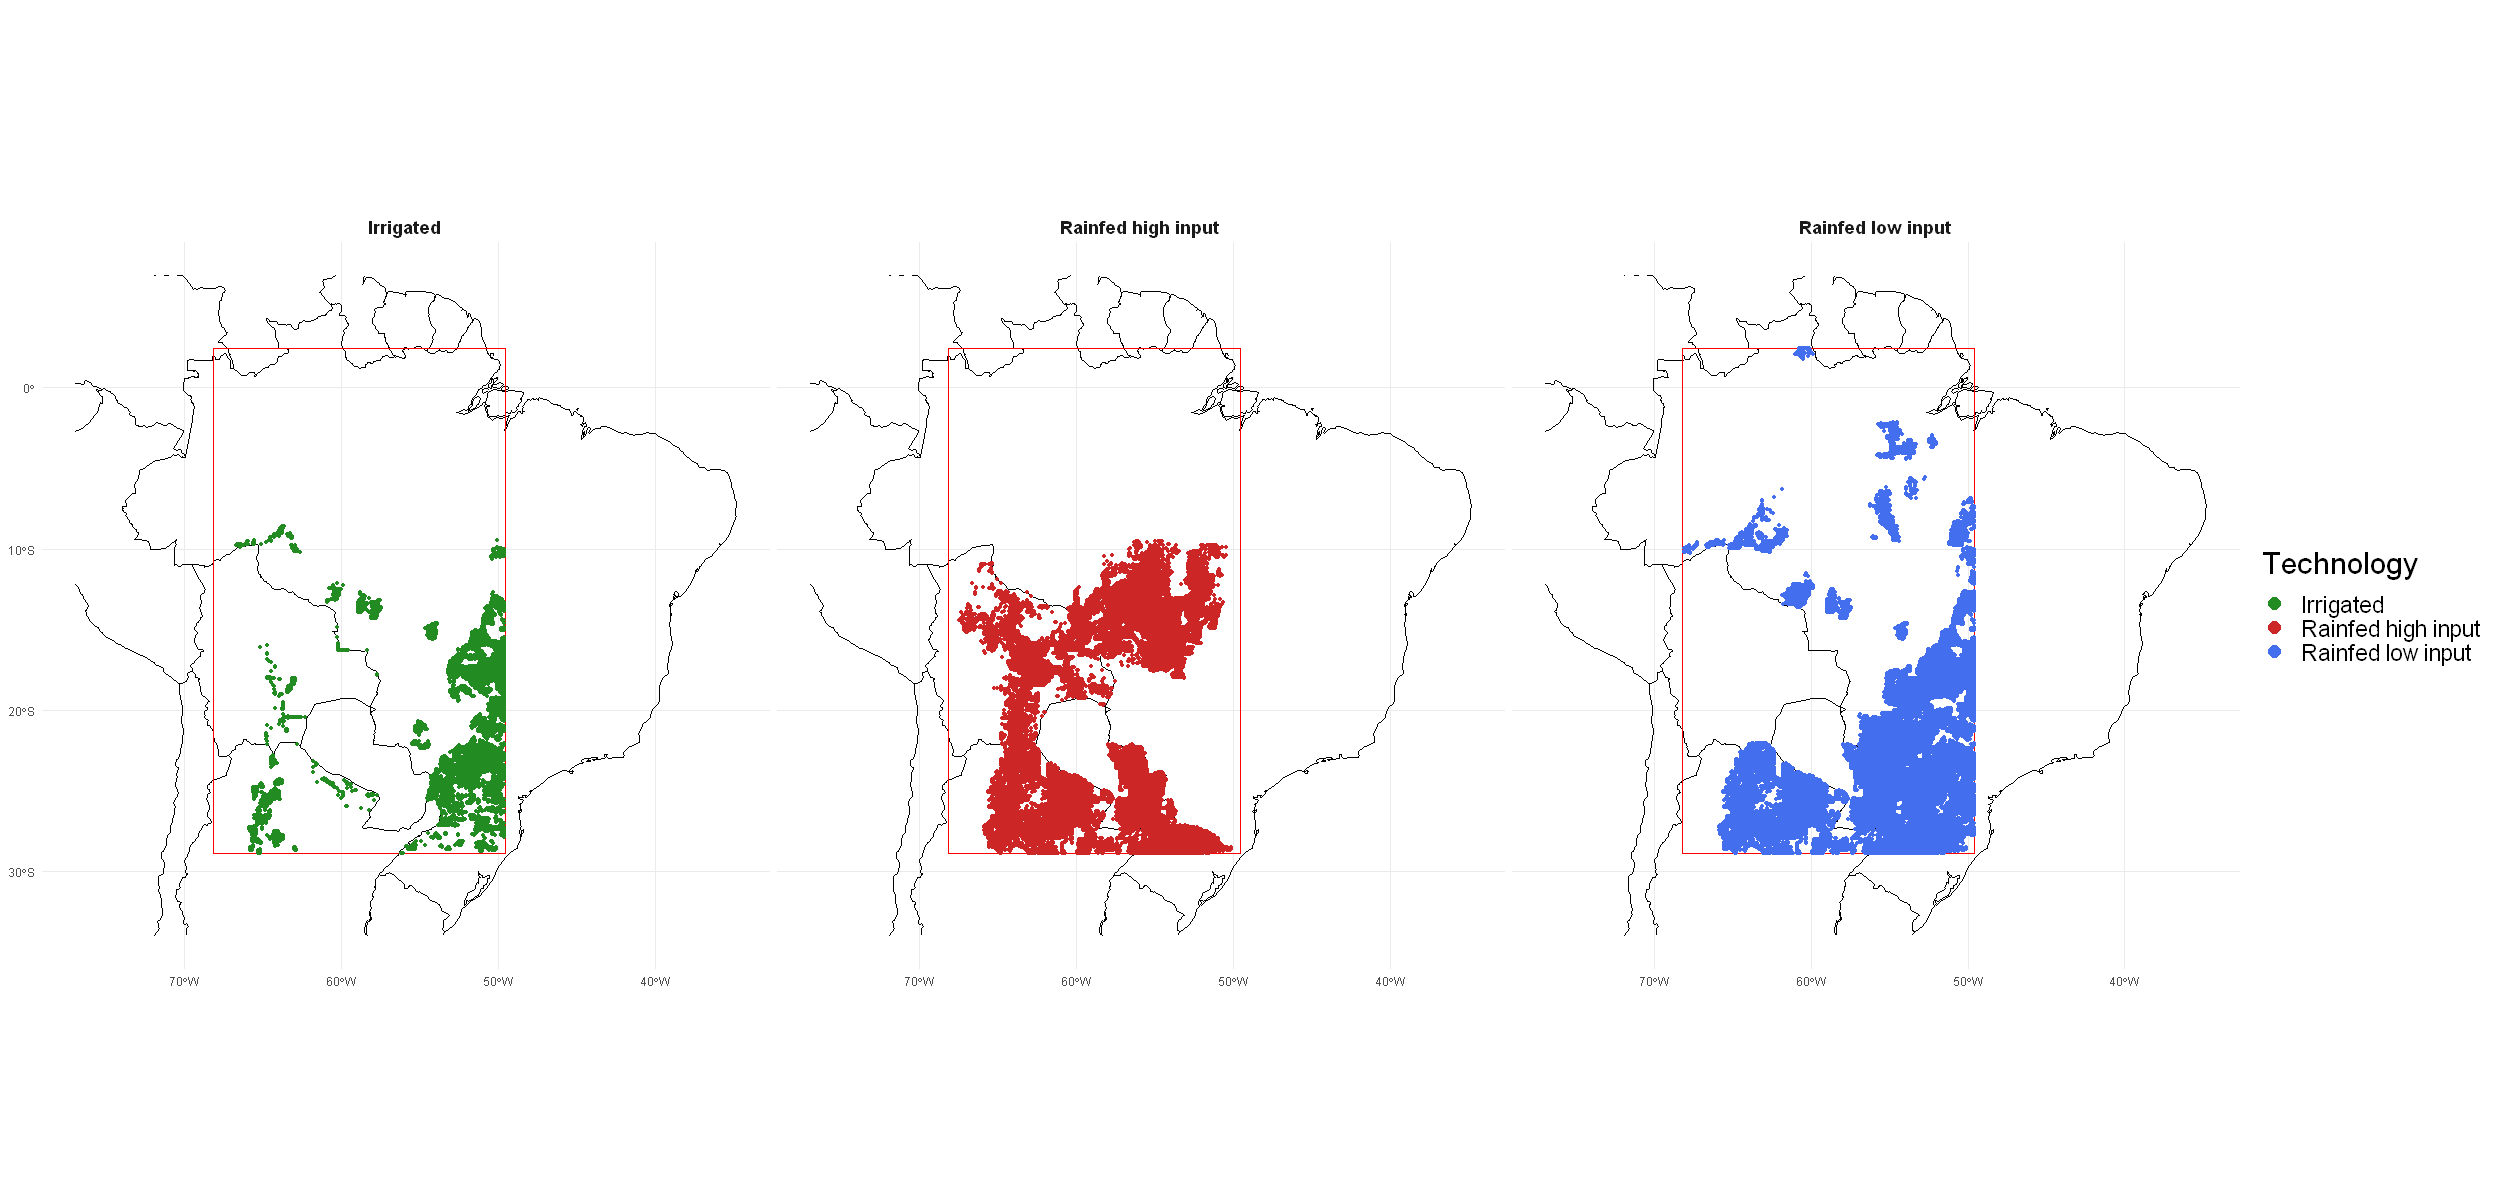

In [23]:
options(repr.plot.width = 25, repr.plot.height = 12, repr.plot.res = 100)
ggplot()+
  geom_sf(data = america_map, fill = "white") +
  geom_sf(data = area_america,color = "red", fill = NA)+
  geom_sf(data = df_america, aes(color=Technology), size = 1)+
  scale_color_manual(values = c("Irrigated"= "forestgreen",
                                "Rainfed high input" = "firebrick3",
                                "Rainfed low input" = "royalblue2",
                                "Rainfed subsistance" = "purple4"))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  theme(strip.text.x = element_text(size=rel(1.5), face = "bold"),
        legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))+
  facet_wrap(~Technology)

This visualization confirms that irrigation is the least extended practice, and that in both regions the extension is similar between high and low input rainfed harvesting methods.

## Further data analysis  
To confirm the trends in extension extracted from the plots, I calculate some basic metrics for each area of interest and technology type.  
I start with a summary table comparing the total area (in hectares) of each production method, as well as the proportion (in percentage) of the total soy crops' physical area with each method. I also calculated the median surface of harvested land in each pixel (10x10kms) in each case.

In [24]:
df_am <- as.data.frame(df_america) %>% mutate("Region" = "S.America")
df_as <- as.data.frame(df_asia) %>% mutate("Region" = "Asia")

df_g1 <- group_by(df_as, Region, Technology) %>% summarise("Total area (ha)" = sum(soy_beans),
                                                            "Percentage area" = paste0(round((sum(soy_beans)/sum(df_as$soy_beans))*100, 2), "%"),
                                                            "Percentage pixels" = paste0(round(n()/nrow(df_as)*100, 2), "%"),
                                                            "Median area (ha) per pixel" = median(soy_beans))

df_g2 <- group_by(df_am, Region, Technology) %>% summarise("Total area (ha)" = sum(soy_beans),
                                                            "Percentage area" = paste0(round((sum(soy_beans)/sum(df_am$soy_beans))*100, 2), "%"),
                                                            "Percentage pixels" = paste0(round(n()/nrow(df_am)*100, 2), "%"),
                                                            "Median area (ha) per pixel" = median(soy_beans))
df_group <- rbind(df_g1, df_g2)
df_group

`summarise()` has grouped output by 'Region'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Region'. You can override using the `.groups` argument.



Region,Technology,Total area (ha),Percentage area,Percentage pixels,Median area (ha) per pixel
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Asia,Irrigated,56867.3,0.66%,17.53%,5.6
Asia,Rainfed high input,4853608.1,55.94%,35.24%,37.2
Asia,Rainfed low input,3763800.4,43.38%,45.49%,26.5
Asia,Rainfed subsistance,2563.8,0.03%,1.74%,0.5
S.America,Irrigated,51139.2,0.22%,13.23%,1.0
S.America,Rainfed high input,11517880.1,50.34%,41.63%,197.1
S.America,Rainfed low input,11309608.1,49.43%,45.13%,113.5


While both regions show similar proportions of harvested area with each of the technologies, the most striking aspect is perhaps the density of crop hectares per pixel.  
In South America, the rainfed crops areas contain 4-5 times more harvested hectares than in Asia, which is an indicator of an intesification of this type of agriculture.
Visualizing the harvested area per pixel for each technology gives an idea of how this trend is distributed.

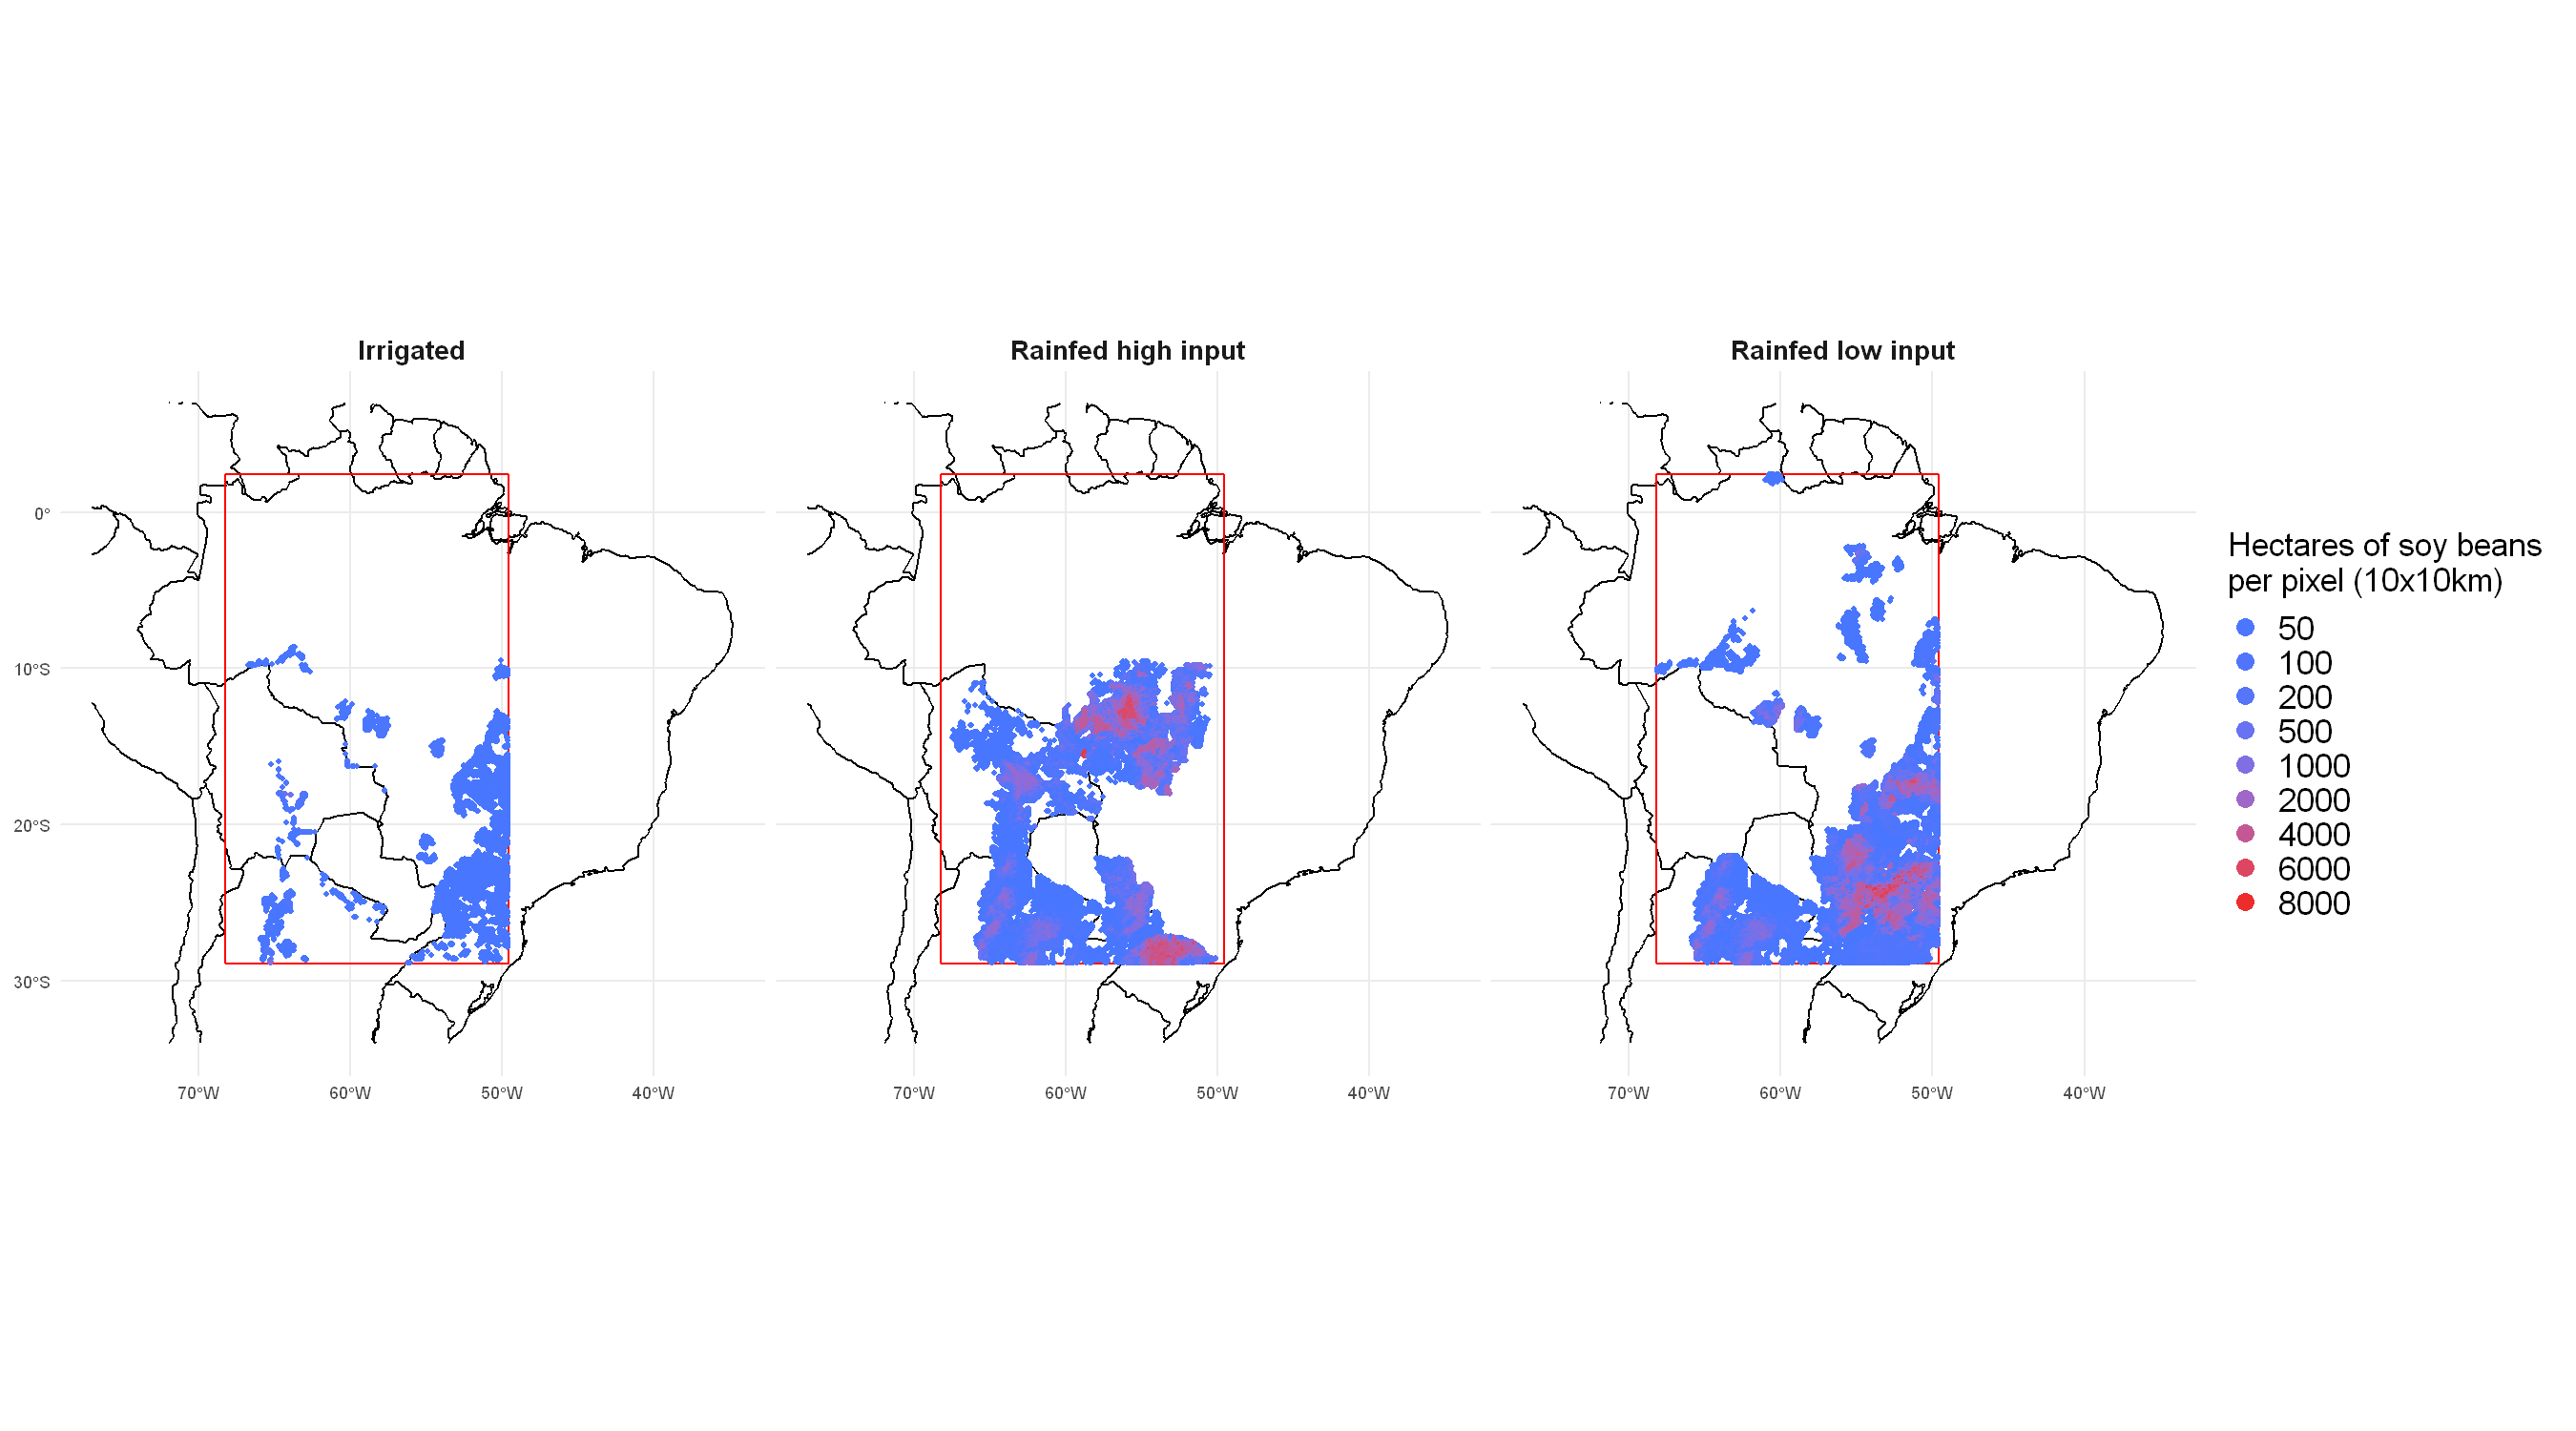

In [25]:
options(repr.plot.width = 18, repr.plot.height = 10, repr.plot.res = 150)
ggplot()+
  geom_sf(data = america_map, fill = "white") +
  geom_sf(data = area_america,color = "red", fill = NA)+
  geom_sf(data = df_america, aes(color=soy_beans), size = 1)+
  scale_color_gradient(low="royalblue1", high="firebrick2",limits = c(0, 8000), breaks = c(50, 100, 200, 500, 1000, 2000, 4000, 6000, 8000))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  labs(color = "Hectares of soy beans\nper pixel (10x10km)")+
  theme(strip.text.x = element_text(size=rel(1.5), face = "bold"),
        legend.title=element_text(size=rel(1.5)), 
        legend.text=element_text(size=rel(1.5)))+
  facet_wrap(~Technology)

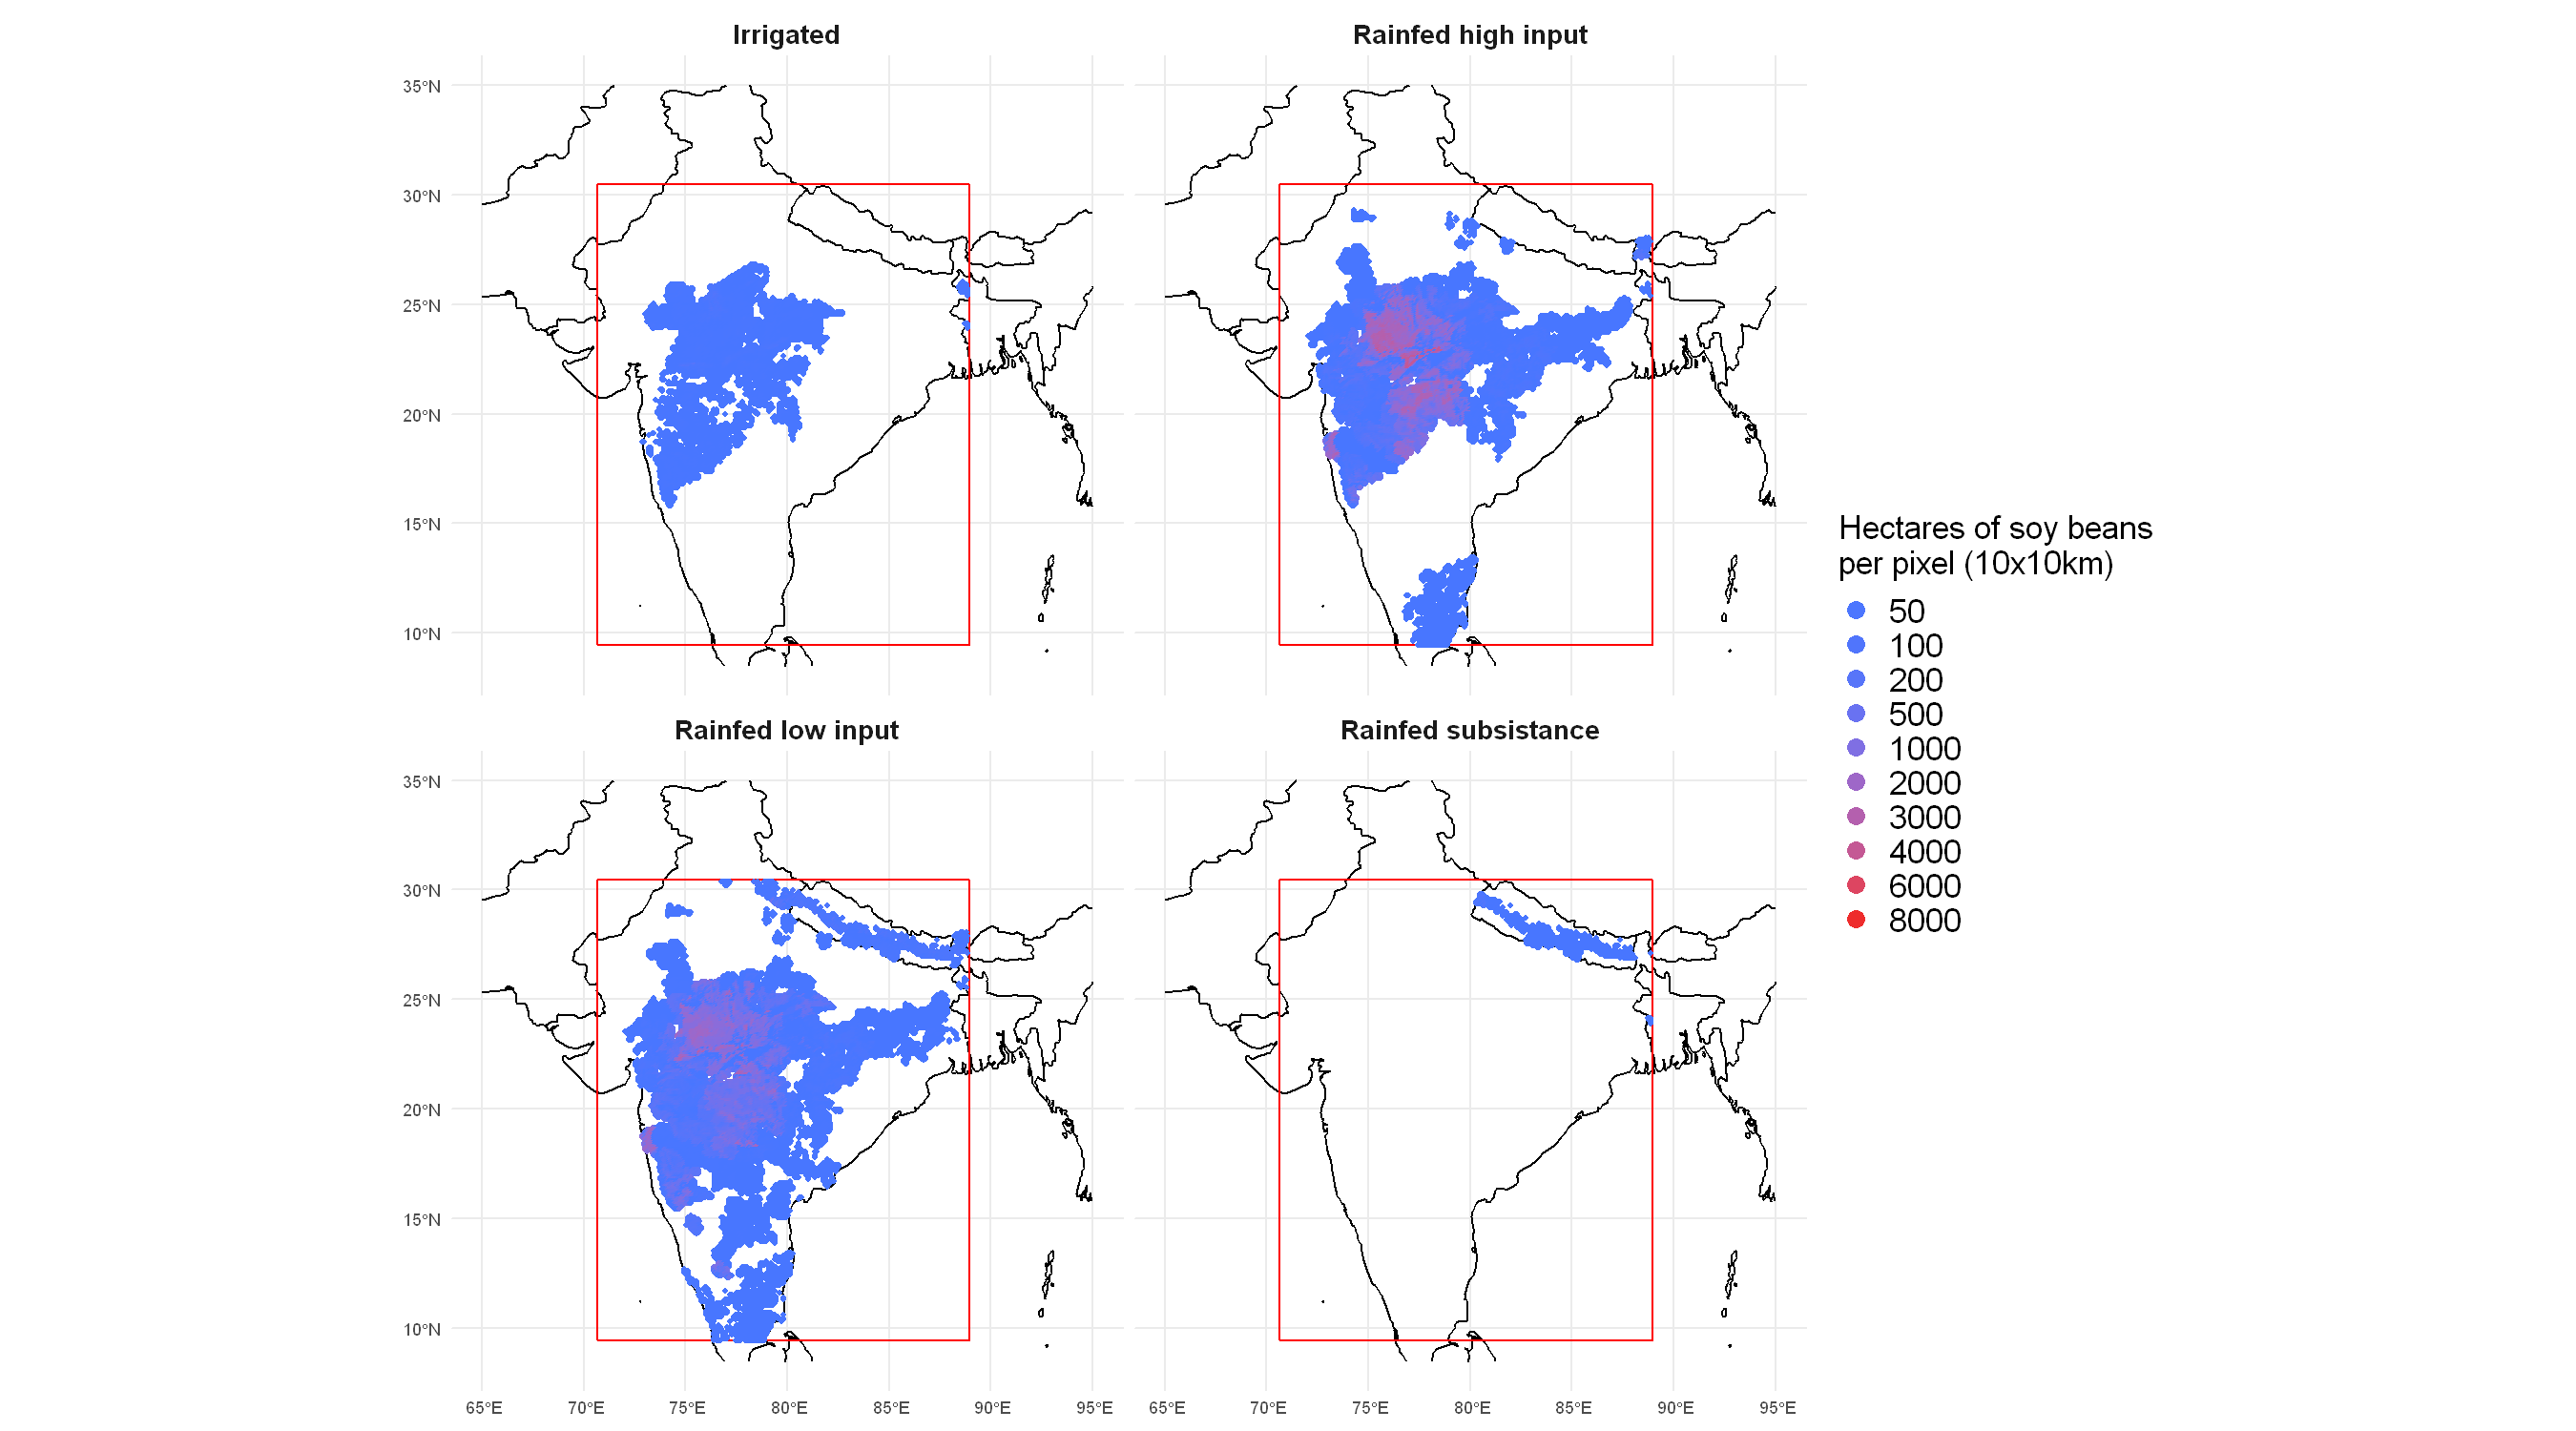

In [26]:
options(repr.plot.width = 18, repr.plot.height = 10, repr.plot.res = 150)
ggplot()+
  geom_sf(data = asia_map, fill = "white") +
  geom_sf(data = area_asia,color = "red", fill = NA)+
  geom_sf(data = df_asia, aes(color=soy_beans), size = 1)+
  scale_color_gradient(low="royalblue1", high="firebrick2", limits = c(0, 8000), breaks = c(50, 100, 200, 500, 1000, 2000, 3000, 4000, 6000, 8000))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  labs(color = "Hectares of soy beans\nper pixel (10x10km)")+
  theme(strip.text.x = element_text(size=rel(1.5), face = "bold"),
        legend.title=element_text(size=rel(1.5)), 
        legend.text=element_text(size=rel(1.5)))+
  facet_wrap(~Technology)

The most densely harvested areas in Asia "only" reach ~4000 hectares per pixel (40% of pixel surface), while in South America it goes over 7000 hectares per pixel (70% of pixel surface).  
The density (both mean and median) is similar between high and low input production methods in South America, with slighly more differences in Asia.
These differences can be clearly seen in the following summary table and histogram.

`summarise()` has grouped output by 'Region'. You can override using the `.groups` argument.



Region,Technology,Median area (ha) per pixel,Mean area,St. dev.,Max value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Asia,Irrigated,5.6,9.61,13.36,195.8
Asia,Rainfed high input,37.2,407.87,729.80,3922.5
Asia,Rainfed low input,26.5,245.04,425.90,3237.7
S.America,Irrigated,1.0,10.34,51.93,1634.0
S.America,Rainfed high input,197.1,740.18,1162.95,7303.0
S.America,Rainfed low input,113.5,670.44,1117.34,7496.9


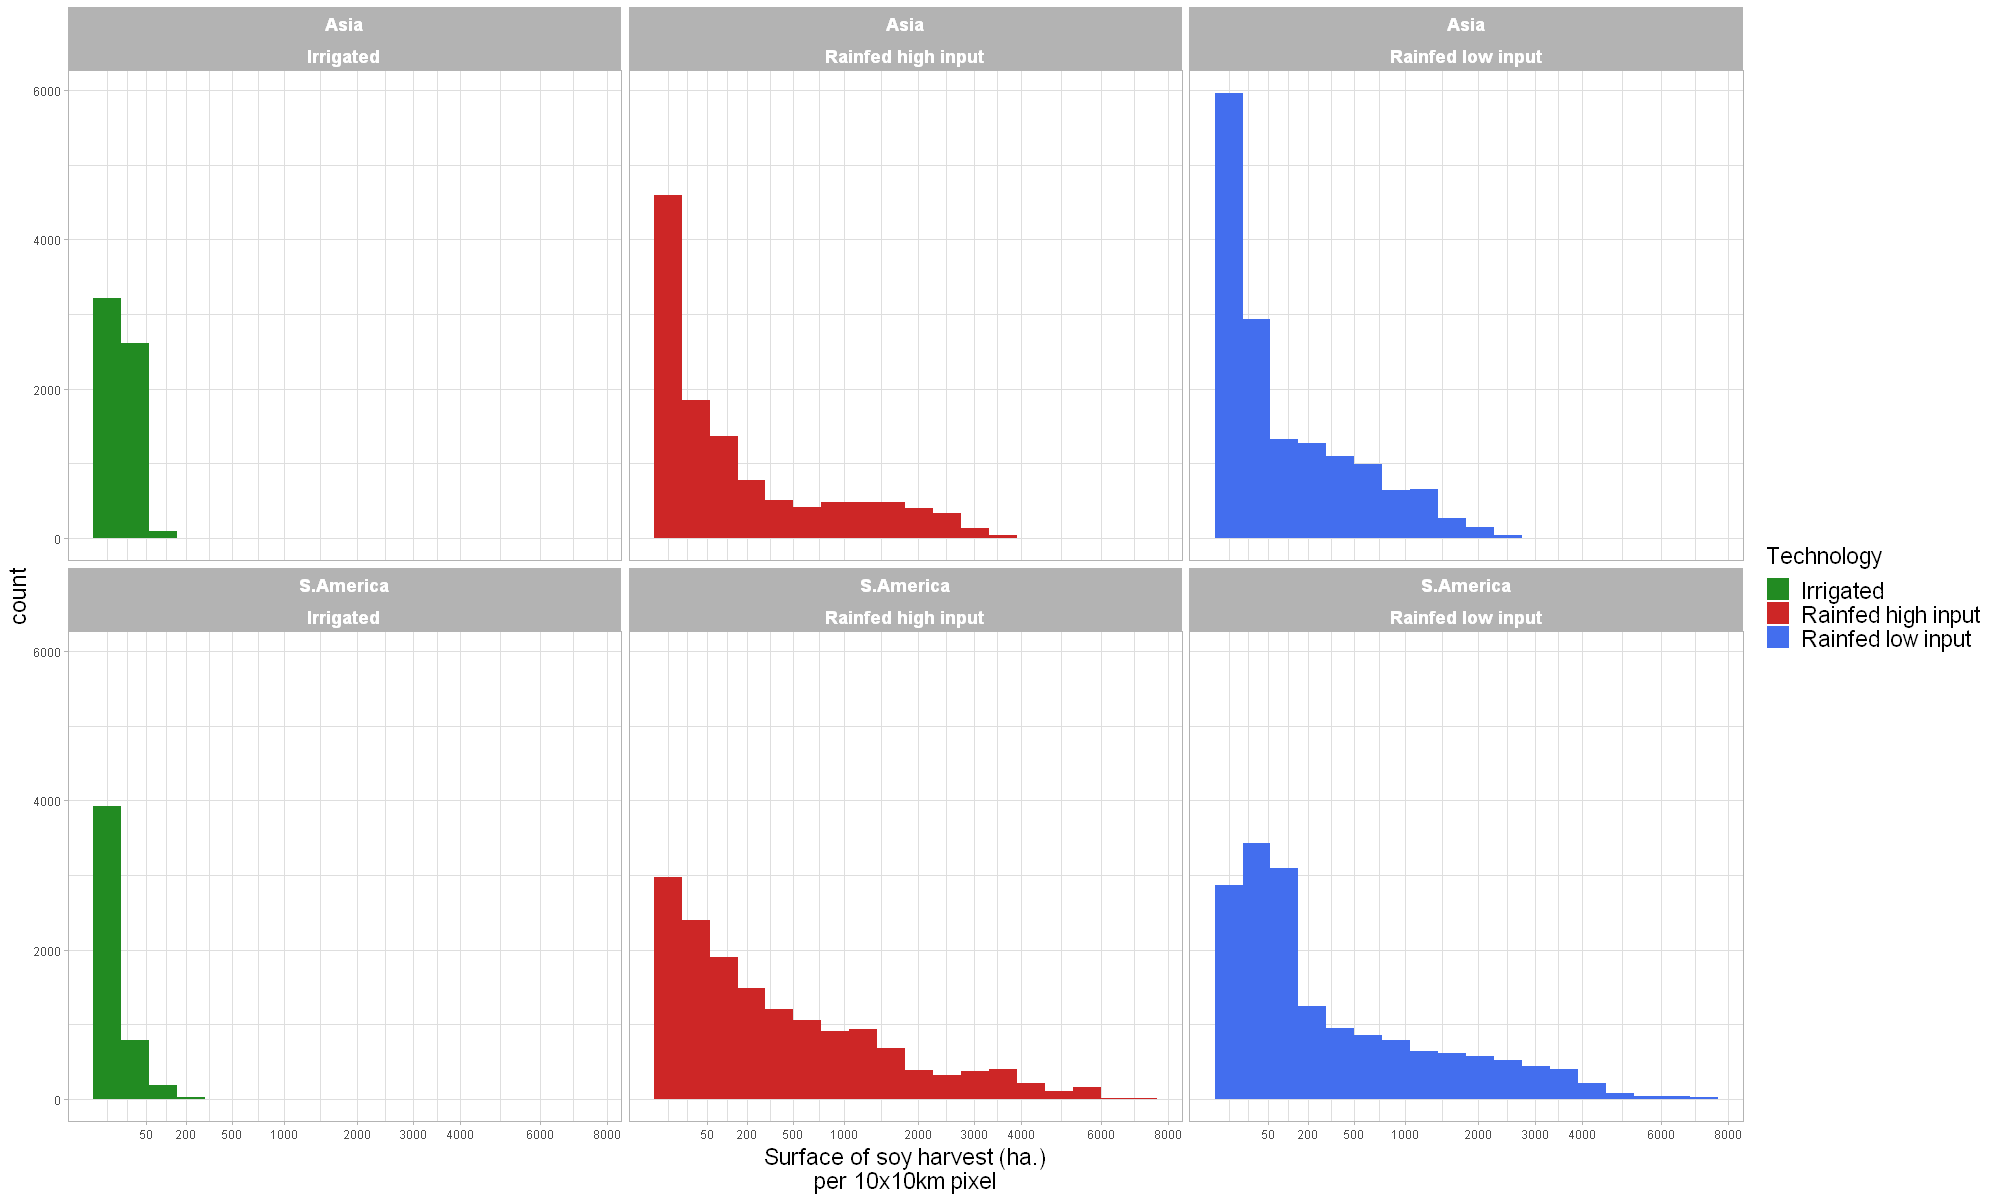

In [33]:
df_joined <- rbind(df_am, df_as) %>% select(soy_beans, Technology, Region) %>% filter(Technology != "Rainfed subsistance")


df_joined %>% group_by(Region, Technology) %>% summarise("Median area (ha) per pixel" = median(soy_beans),
                                                        "Mean area" = round(mean(soy_beans),2),
                                                        "St. dev." = round(sd(soy_beans),2),
                                                        "Max value" = max(soy_beans))


options(repr.plot.width = 20, repr.plot.height = 12, repr.plot.res = 100)

#ggplot(df_joined, aes(x=Technology, y=soy_beans))+
#    geom_boxplot()+
#    facet_wrap(~Region)

ggplot(df_joined, aes(x=soy_beans, fill=Technology))+
       geom_histogram(position = 'identity', binwidth=5) +
       scale_fill_manual(values = c("Irrigated"= "forestgreen",
                                "Rainfed high input" = "firebrick3",
                                "Rainfed low input" = "royalblue2"))+
       xlab("Surface of soy harvest (ha.)\nper 10x10km pixel")+
       scale_x_sqrt(breaks = c(50,200, 500, 1000, 2000, 3000, 4000, 6000, 8000))+
       facet_wrap(Region~Technology)+
       theme_light()+
       theme(strip.text.x = element_text(size=rel(1.5), face = "bold"),
             legend.title=element_text(size=rel(1.5)), 
             legend.text=element_text(size=rel(1.5)),
             axis.title.x = element_text(size=rel(1.5)),
             axis.title.y = element_text(size=rel(1.5)))


## Main conclussions  

The data used for this exercise represents the area of crop with one of the highest increases in demand, in two of the areas of the world with the highest production of soy beans. Those areas partially include Brazil and Argentina, which are repectively the top and third producers in the world, and also India which is also in the top 10.  
The main take-away insight is the high density of soy crops in the cultivated area in South America even compared to India, but even more considering that the most exploited areas fall within the Amazon and Cerrado regions. Those two ecosystems are among the most threatened by deforestation in the continent, and are major representatives of this global problem.

## Some ideas left

Some of the things that could help better contextualize the data, but have not been performed, are:  
- Comparison of total soy area/crop density in proportion to total harvested area and/or with the main crop in each region.  
- Differences in the areas of intense soy production and the main areas for other important crops (e.g. rice, wheat, ...)